In [1]:
import pandas as pd
import numpy as np
import pickle
import random
from pathlib import Path

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [4]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [5]:
from pathlib import Path

TEST_PATH = 'test.csv'
TRAIN_PATH = 'train.csv'




In [6]:
df = pd.read_csv(TRAIN_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [7]:
df.shape

(7500, 17)

In [8]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

In [9]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [10]:
NUM_FEATURE_NAMES = ['Annual Income'
                     , 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                     'Bankruptcies', 'Number of Credit Problems',
                     'Months since last delinquent',                     
                    'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score'
                    ]

CAT_FEATURE_NAMES =  ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES  + CAT_FEATURE_NAMES #+ NEW_FEATURE_NAMES
#Remove: Bankruptcies, Number of Credit Problems, Tax Liens

In [11]:
for cat_colname in CAT_FEATURE_NAMES:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [12]:
df.loc[df['Years in current job'] == '< 1 year', ['Years in current job']] = 0
df.loc[df['Years in current job'] == '1 year', ['Years in current job']] = 1
df.loc[df['Years in current job'] == '2 years', ['Years in current job']] = 2
df.loc[df['Years in current job'] == '3 years', ['Years in current job']] = 3
df.loc[df['Years in current job'] == '4 years', ['Years in current job']] = 4
df.loc[df['Years in current job'] == '5 years', ['Years in current job']] = 5
df.loc[df['Years in current job'] == '6 years', ['Years in current job']] = 6
df.loc[df['Years in current job'] == '7 years', ['Years in current job']] = 7
df.loc[df['Years in current job'] == '8 years', ['Years in current job']] = 8
df.loc[df['Years in current job'] == '9 years', ['Years in current job']] = 9
df.loc[df['Years in current job'] == '10+ years', ['Years in current job']] = 10
df.loc[df['Years in current job'].isna(), ['Years in current job']] = -1


df.loc[df['Purpose'] == 'debt consolidation', ['Purpose']] = 1
df.loc[df['Purpose'] == 'other', ['Purpose']] = 2
df.loc[df['Purpose'] == 'home improvements', ['Purpose']] = 3
df.loc[df['Purpose'] == 'business loan', ['Purpose']] = 4
df.loc[df['Purpose'] == 'buy a car', ['Purpose']] = 5
df.loc[df['Purpose'] == 'medical bills', ['Purpose']] = 6
df.loc[df['Purpose'] == 'major purchase', ['Purpose']] = 7
df.loc[df['Purpose'] == 'take a trip', ['Purpose']] = 8
df.loc[df['Purpose'] == 'buy house', ['Purpose']] = 9
df.loc[df['Purpose'] == 'small business', ['Purpose']] = 10
df.loc[df['Purpose'] == 'wedding', ['Purpose']] = 11
df.loc[df['Purpose'] == 'moving', ['Purpose']] = 12
df.loc[df['Purpose'] == 'educational expenses', ['Purpose']] = 13
df.loc[df['Purpose'] == 'vacation', ['Purpose']] = 14
df.loc[df['Purpose'] == 'renewable energy', ['Purpose']] = 15
df.loc[df['Purpose'].isna(), ['Purpose']] = -1


df.loc[df['Term'] == 'Short Term', ['Term']] = 0
df.loc[df['Term'] == 'Long Term', ['Term']] = 1
df.loc[df['Term'].isna(), ['Term']] = -1


df.loc[df['Home Ownership'] == 'Home Mortgage', ['Home Ownership']] = 0
df.loc[df['Home Ownership'] == 'Rent', ['Home Ownership']] = 1
df.loc[df['Home Ownership'] == 'Own Home', ['Home Ownership']] = 2
df.loc[df['Home Ownership'] == 'Have Mortgage', ['Home Ownership']] = 3
df.loc[df['Home Ownership'].isna(), ['Home Ownership']] = -1






df[['Years in current job', 'Purpose', 'Term', 'Home Ownership']] = df[['Years in current job', 'Purpose', 'Term', 'Home Ownership']].astype(float)



In [13]:
for cat_colname in CAT_FEATURE_NAMES:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

0.0    3637
1.0    3204
2.0     647
3.0      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

 10.0    2332
 2.0      705
 3.0      620
 0.0      563
 5.0      516
 1.0      504
 4.0      469
 6.0      426
 7.0      396
-1.0      371
 8.0      339
 9.0      259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

1.0     5944
2.0      665
3.0      412
4.0      129
5.0       96
6.0       71
7.0       40
8.0       37
9.0       34
10.0      26
11.0      15
12.0      11
13.0      10
14.0       8
15.0       2
Name: Purpose, dtype: int64
****************************************************************************************************

Term

0.0    5556
1.0    1944
Name: Term, dtype: int64
*****************************************************************************

In [14]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [15]:
#df.loc[df['Annual Income' or 'Number of Open Accounts' or 'Years of Credit History' or 'Maximum Open Credit' or 'Number of Credit Problems'
#         or 'Months since last delinquent' or 'Bankruptcies' or 'Current Loan Amount' or 'Current Credit Balance' or 'Monthly Debt'
#         or 'Credit Score'].isna()] = 0
df.loc[df['Annual Income'].isna(), ['Annual Income']] = df['Annual Income'].mean()
df.loc[df['Number of Open Accounts'].isna(), ['Number of Open Accounts']] = df['Number of Open Accounts'].mean()
df.loc[df['Years of Credit History'].isna(), ['Years of Credit History']] = df['Years of Credit History'].mean()

df.loc[df['Months since last delinquent'].isna(), ['Months since last delinquent']] = df['Months since last delinquent'].mean()
df.loc[df['Bankruptcies'].isna(), ['Bankruptcies']] = df['Bankruptcies'].mean()

df.loc[df['Years of Credit History'].isna(), ['Years of Credit History']] = df['Years of Credit History'].mean()
df.loc[df['Number of Credit Problems'].isna(), ['Number of Credit Problems']] = df['Number of Credit Problems'].mean()
df.loc[df['Maximum Open Credit'].isna(), ['Maximum Open Credit']] = df['Maximum Open Credit'].mean()
df.loc[df['Months since last delinquent'].isna(), ['Months since last delinquent']] = df['Months since last delinquent'].mean()
df.loc[df['Bankruptcies'].isna(), ['Bankruptcies']] = df['Bankruptcies'].mean()
df.loc[df['Current Loan Amount'].isna(), ['Current Loan Amount']] = df['Current Loan Amount'].mean()
df.loc[df['Current Credit Balance'].isna(), ['Current Credit Balance']] = df['Current Credit Balance'].mean()
df.loc[df['Monthly Debt'].isna(), ['Monthly Debt']] = df['Monthly Debt'].mean()
df.loc[df['Credit Score'].isna(), ['Credit Score']] = df['Credit Score'].mean()
" , ".join(df.columns)






'Home Ownership , Annual Income , Years in current job , Tax Liens , Number of Open Accounts , Years of Credit History , Maximum Open Credit , Number of Credit Problems , Months since last delinquent , Bankruptcies , Purpose , Term , Current Loan Amount , Current Credit Balance , Monthly Debt , Credit Score , Credit Default'

In [16]:
df[pd.isna(df['Years in current job'])]


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler


def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=10,
                                  random_state=42,
                                  verbose=1)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

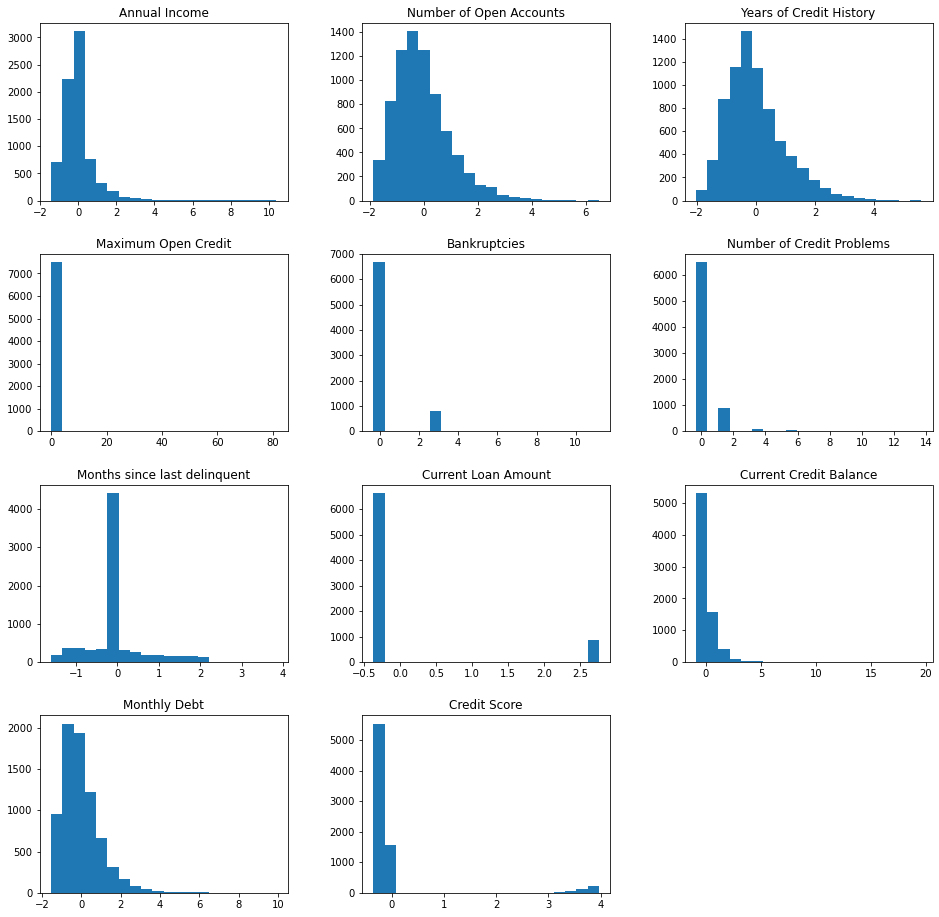

In [18]:
df[NUM_FEATURE_NAMES].hist(figsize=(16, 16), bins=20, grid=False);

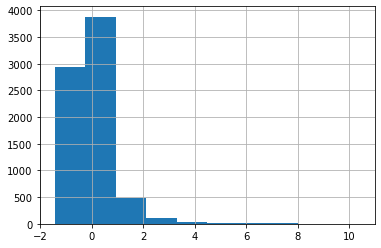

In [19]:
def preprocess_outlier(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    
    df.loc[df[col] > threshold, col] = np.nan
    return df




def preprocess_underlier(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[col] < threshold, col] = np.nan
    return df

feature_name = 'Annual Income'
df[feature_name].hist();

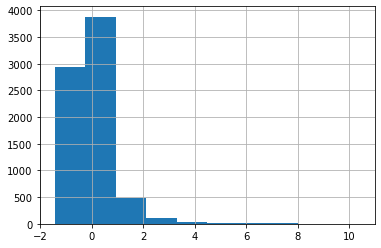

In [20]:
df[feature_name].hist();

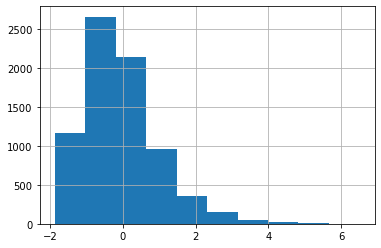

In [21]:
feature_name = 'Number of Open Accounts'
df[feature_name].hist();

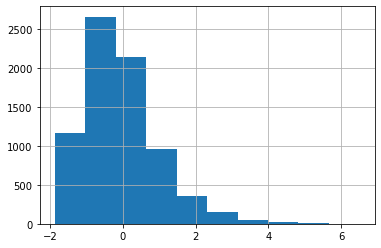

In [22]:
df[feature_name].hist();

In [23]:
feature_name = 'Years of Credit History'

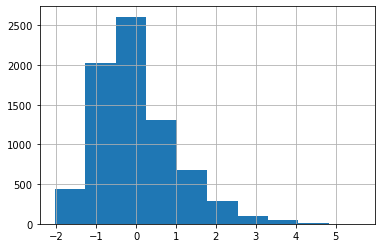

In [24]:
df[feature_name].hist();

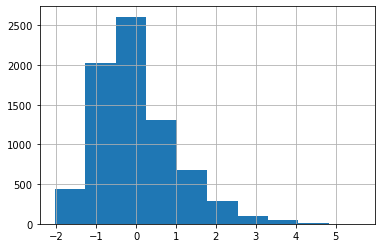

In [25]:
df[feature_name].hist();

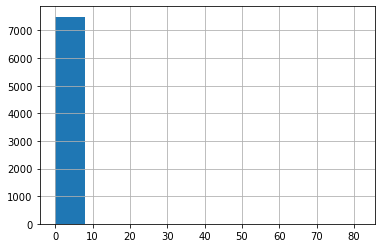

In [26]:
feature_name = 'Maximum Open Credit'
df[feature_name].hist();

In [27]:
df = preprocess_outlier(df, feature_name, threshold= 0.1)


bill_amt1_predictor, df = imputer_rfr(df, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.8533504206298789
r2 на test: 0.6503334040028941


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


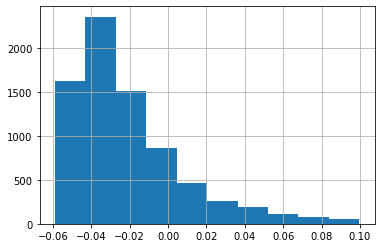

In [28]:
df[feature_name].hist();

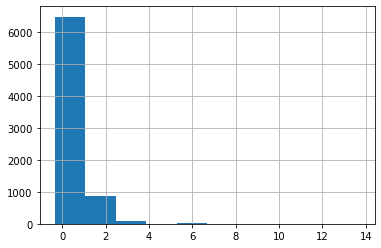

In [29]:
feature_name = 'Number of Credit Problems'
df[feature_name].hist();

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9419134574741062
r2 на test: 0.8922683989503277


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


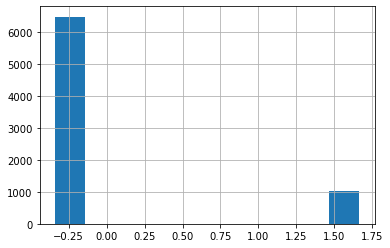

In [30]:
df = preprocess_outlier(df, feature_name, threshold=2)

bill_amt1_predictor, df = imputer_rfr(df, feature_name)
df[feature_name].hist();

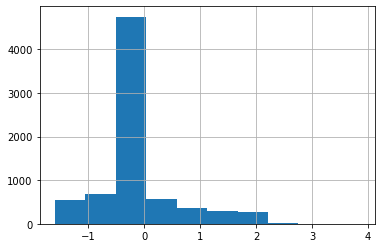

In [31]:
feature_name = 'Months since last delinquent'
df[feature_name].hist();

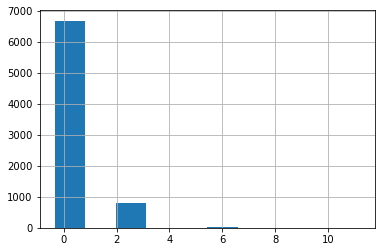

In [32]:
feature_name = 'Bankruptcies'
df[feature_name].hist();

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9625945039983748
r2 на test: 0.8586033886612372


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


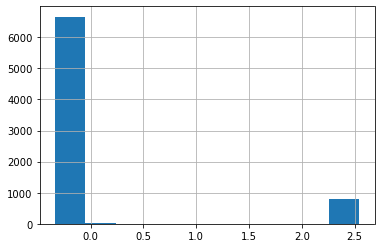

In [33]:
df = preprocess_outlier(df, feature_name, threshold=3)


bill_amt1_predictor, df = imputer_rfr(df, feature_name)
df[feature_name].hist();

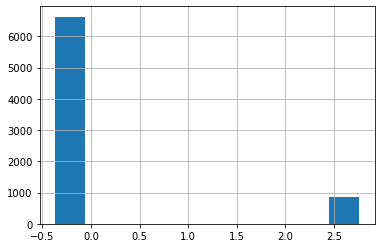

In [34]:
feature_name = 'Current Loan Amount'
df[feature_name].hist();

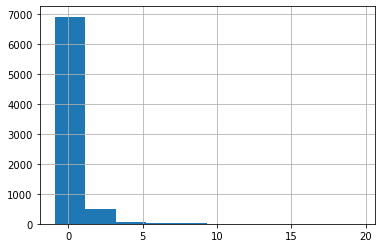

In [35]:
feature_name = 'Current Credit Balance'
df[feature_name].hist();

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


r2 на train: 0.871384682569101
r2 на test: 0.7066836030922281


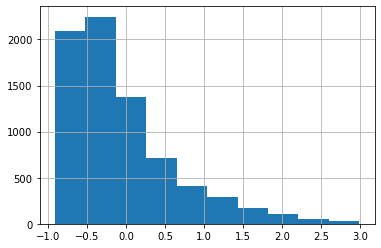

In [36]:
df = preprocess_outlier(df, feature_name, threshold=3)

bill_amt1_predictor, df = imputer_rfr(df, feature_name)
df[feature_name].hist();

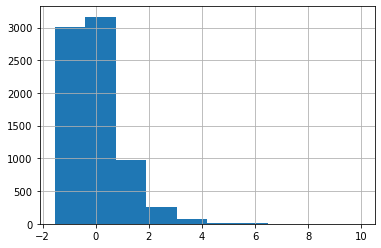

In [37]:
feature_name = 'Monthly Debt'
df[feature_name].hist();

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


r2 на train: 0.7379192803739121
r2 на test: 0.49336993716464095


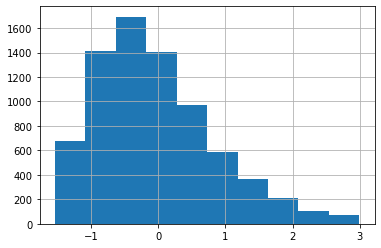

In [38]:
df = preprocess_outlier(df, feature_name, threshold=3)

bill_amt1_predictor, df = imputer_rfr(df, feature_name)
df[feature_name].hist();

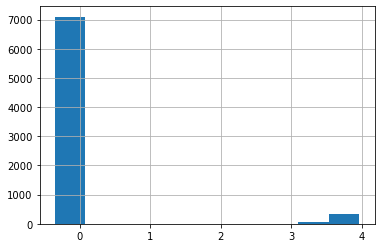

In [39]:
feature_name = 'Credit Score'
df[feature_name].hist();

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


r2 на train: 0.9933904647722328
r2 на test: 0.9875705365082313


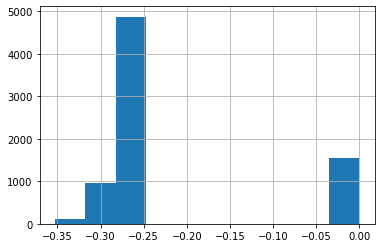

In [40]:
df = preprocess_outlier(df, feature_name, threshold=1)

bill_amt1_predictor, df = imputer_rfr(df, feature_name)
df[feature_name].hist();

In [41]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,2.0,-1.046183,-1.0,0.0,-0.026674,1.133645,-0.016174,1.664779,9.241576e-17,2.542995,1.0,0.0,2.760520,-0.762772,-0.872085,-0.250629,0
1,2.0,-0.403310,10.0,0.0,0.788223,-0.428528,0.014763,-0.340979,9.241576e-17,-0.337450,1.0,1.0,-0.363620,0.330781,0.004909,-0.258108,1
2,0.0,-0.727556,8.0,0.0,-0.026674,2.369181,0.014807,-0.340979,9.241576e-17,-0.337450,1.0,0.0,2.760520,0.058379,-0.391034,-0.254992,0
3,2.0,-0.664078,6.0,0.0,-0.637847,0.593985,-0.049781,1.664779,9.241576e-17,2.542995,1.0,0.0,-0.368118,-0.610282,-0.584980,-0.284911,0
4,1.0,-0.698155,8.0,0.0,0.380774,-0.669954,-0.034902,1.664779,9.241576e-17,-0.337450,1.0,0.0,-0.367978,-0.618292,-0.933631,-0.269328,0


In [42]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y
                                                   )

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

In [43]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [44]:
#Логистическая регрессия
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

evaluate_preds(model_lr, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.95      0.84      3771
           1       0.58      0.16      0.25      1479

    accuracy                           0.73      5250
   macro avg       0.66      0.56      0.54      5250
weighted avg       0.70      0.73      0.67      5250

TEST

              precision    recall  f1-score   support

           0       0.73      0.93      0.82      1616
           1       0.44      0.13      0.21       634

    accuracy                           0.71      2250
   macro avg       0.59      0.53      0.51      2250
weighted avg       0.65      0.71      0.65      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1509  107
1                549   85


KNN ближайших соседей

In [45]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

evaluate_preds(model_knn, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      3771
           1       0.69      0.43      0.53      1479

    accuracy                           0.79      5250
   macro avg       0.75      0.68      0.69      5250
weighted avg       0.77      0.79      0.77      5250

TEST

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      1616
           1       0.37      0.21      0.27       634

    accuracy                           0.68      2250
   macro avg       0.55      0.53      0.53      2250
weighted avg       0.63      0.68      0.64      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1386  230
1                500  134


Дерево решений

In [46]:
model_tree = DecisionTreeClassifier(random_state=21,
                                    class_weight={0:1, 1:3.6},
                                    
                                    max_depth=4
                                    )
model_tree.fit(X_train, y_train)

evaluate_preds(model_tree, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.27      0.42      3771
           1       0.34      0.97      0.51      1479

    accuracy                           0.47      5250
   macro avg       0.65      0.62      0.46      5250
weighted avg       0.78      0.47      0.45      5250

TEST

              precision    recall  f1-score   support

           0       0.93      0.28      0.43      1616
           1       0.34      0.95      0.50       634

    accuracy                           0.47      2250
   macro avg       0.64      0.61      0.46      2250
weighted avg       0.76      0.47      0.45      2250

CONFUSION MATRIX

col_0             0     1
Credit Default           
0               446  1170
1                33   601


XGBoost

In [47]:
%%time
model_xgb = xgb.XGBClassifier(random_state=21,
#                               n_estimators=100
                             )
model_xgb.fit(X_train, y_train)

evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

[13:04:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3771
           1       0.99      0.88      0.93      1479

    accuracy                           0.97      5250
   macro avg       0.97      0.94      0.96      5250
weighted avg       0.97      0.97      0.96      5250

TEST

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1616
           1       0.49      0.29      0.36       634

    accuracy                           0.71      2250
   macro avg       0.62      0.58      0.59      2250
weighted avg       0.68      0.71      0.69      2250

CONFUSION MATRIX

col_0

LightGBM

In [48]:
%%time
model_lgbm = lgbm.LGBMClassifier(random_state=21, 
                                 class_weight={0:1.3, 1:4},
                                 categorical_feature  = [-4, -3,-2,-1],
                                 max_depth = 7,
                                 
#                                  n_estimators=100
                                )
model_lgbm.fit(X_train, y_train)

evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
TRAIN

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      3771
           1       0.63      0.96      0.76      1479

    accuracy                           0.83      5250
   macro avg       0.81      0.87      0.82      5250
weighted avg       0.88      0.83      0.84      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.64      0.72      1616
           1       0.41      0.62      0.49       634

    accuracy                           0.64      2250
   macro avg       0.61      0.63      0.61      2250
weighted avg       0.70      0.64      0.66      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1041  575
1                239  395
Wall time: 204 ms


CatBoost

In [49]:
%%time
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      3771
           1       0.96      0.56      0.71      1479

    accuracy                           0.87      5250
   macro avg       0.90      0.78      0.81      5250
weighted avg       0.88      0.87      0.86      5250

TEST

              precision    recall  f1-score   support

           0       0.75      0.92      0.83      1616
           1       0.53      0.23      0.32       634

    accuracy                           0.73      2250
   macro avg       0.64      0.57      0.57      2250
weighted avg       0.69      0.73      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1488  128
1                490  144
Wall time: 3.74 s


Балансировка целевой переменной

In [50]:
import inspect

In [51]:
def init_models():
    model_lr = LogisticRegression(random_state=21)
    model_knn = KNeighborsClassifier()
    model_tree = DecisionTreeClassifier(random_state=21)
    model_xgb = xgb.XGBClassifier(random_state=21)
    model_lgbm = lgbm.LGBMClassifier(random_state=21, max_depth = 6, class_weight={0:1.4, 1:3})
    model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

    models = {
        'lr': model_lr,
        'knn': model_knn,
        'tree': model_tree,
        'xgb': model_xgb,
        'lgbm': model_lgbm,
        'cat': model_catb
    }
    return models


                           

In [52]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [53]:
def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    return f1_macro, f1_0, f1_1

In [54]:
def run_experiment(X_train, X_test, y_train, y_test, method='not'):
    assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'Неправильный метод сэмплирования'
    
    models = init_models()
    
    stata = pd.DataFrame()
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        report_train = classification_report(y_train, pred_train, output_dict=True)
        report_test = classification_report(y_test, pred_test, output_dict=True)
        f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)

        stata = stata.append({
            'model_name': name,
            f'f1_macro_train_{method}': f1_macro_train,
            f'f1_macro_test_{method}': f1_macro_test,
            f'f1_0_train_{method}': f1_0_train,
            f'f1_0_test_{method}': f1_0_test,
            f'f1_1_train_{method}': f1_1_train,
            f'f1_1_test_{method}': f1_1_test
        }, ignore_index=True)
    return stata, models

In [55]:
#df = pd.read_csv(TRAIN_PATH)
df[NUM_FEATURE_NAMES] = scaler.transform(df[NUM_FEATURE_NAMES])

X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

In [56]:
%%time
stata_not_balanced, models_not_balanced = run_experiment(X_train, X_test, y_train, y_test, method='not')
stata_not_balanced

[13:04:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Wall time: 5.74 s


,f1_0_test_not,f1_0_train_not,f1_1_test_not,f1_1_train_not,f1_macro_test_not,f1_macro_train_not,model_name
0,0.830089,0.833876,0.074499,0.073889,0.452294,0.453882,lr
1,0.796155,0.853703,0.251298,0.471673,0.523726,0.662688,knn
2,0.734707,1.000000,0.344136,1.000000,0.539421,1.000000,tree
3,0.806081,0.964585,0.333333,0.899452,0.569707,0.932018,xgb
4,0.764117,0.896763,0.478230,0.775053,0.621174,0.835908,lgbm
5,0.823006,0.903680,0.293008,0.650199,0.558007,0.776939,cat


Oversampling

In [57]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [58]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [59]:
%%time
stata_balanced_over, models_over = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='over')
stata_balanced_over

[13:04:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Wall time: 6.35 s


,f1_0_test_over,f1_0_train_over,f1_1_test_over,f1_1_train_over,f1_macro_test_over,f1_macro_train_over,model_name
0,0.768807,0.693652,0.385366,0.470922,0.577087,0.582287,lr
1,0.737267,0.779846,0.339062,0.687174,0.538165,0.733510,knn
2,0.728808,1.000000,0.334612,1.000000,0.531710,1.000000,tree
3,0.787879,0.966003,0.416667,0.956815,0.602273,0.961409,xgb
4,0.660909,0.782622,0.508438,0.808279,0.584673,0.795451,lgbm
5,0.773384,0.887315,0.450533,0.852785,0.611958,0.870050,cat


Undersampling

In [60]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')
    
df_balanced[TARGET_NAME].value_counts()

1    1479
0    1479
Name: Credit Default, dtype: int64

In [61]:
X_train_balanced_under = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced_under = df_balanced[TARGET_NAME]

In [62]:
%%time
stata_balanced_under, models_under = run_experiment(X_train_balanced_under, X_test, y_train_balanced_under, y_test, method='under')
stata_balanced_under

[13:04:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Wall time: 4.81 s


,f1_0_test_under,f1_0_train_under,f1_1_test_under,f1_1_train_under,f1_macro_test_under,f1_macro_train_under,model_name
0,0.753769,0.654493,0.404255,0.516626,0.579012,0.585559,lr
1,0.646024,0.724093,0.393245,0.698727,0.519634,0.711410,knn
2,0.619489,1.000000,0.429761,1.000000,0.524625,1.000000,tree
3,0.677794,0.989865,0.490826,0.989851,0.584310,0.989858,xgb
4,0.541720,0.800161,0.504854,0.854556,0.523287,0.827358,lgbm
5,0.686751,0.885324,0.505444,0.887475,0.596098,0.886400,cat


Undersampling (Tomeklinks)

In [63]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
X_train_balanced, y_train_balanced = tl.fit_resample(X_train, y_train)

y_train_balanced.value_counts()

0    3212
1    1479
Name: Credit Default, dtype: int64

In [64]:
%%time
stata_balanced_tomek, models_tomek = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='tomek')
stata_balanced_tomek

[13:04:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Wall time: 5.06 s


,f1_0_test_tomek,f1_0_train_tomek,f1_1_test_tomek,f1_1_train_tomek,f1_macro_test_tomek,f1_macro_train_tomek,model_name
0,0.812155,0.810133,0.227273,0.281489,0.519714,0.545811,lr
1,0.773964,0.852312,0.317857,0.584890,0.545911,0.718601,knn
2,0.720612,1.000000,0.355621,1.000000,0.538116,1.000000,tree
3,0.799169,0.976474,0.400354,0.945698,0.599762,0.961086,xgb
4,0.742434,0.881796,0.498034,0.788833,0.620234,0.835314,lgbm
5,0.812047,0.903002,0.380134,0.726161,0.596091,0.814582,cat


Oversampling (SMOTE)

In [65]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

y_train_balanced.value_counts()

1    3771
0    3771
Name: Credit Default, dtype: int64

In [66]:
%%time
stata_balanced_smote, models_smote = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='smote')
stata_balanced_smote

[13:04:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Wall time: 7.55 s


,f1_0_test_smote,f1_0_train_smote,f1_1_test_smote,f1_1_train_smote,f1_macro_test_smote,f1_macro_train_smote,model_name
0,0.729932,0.630714,0.416022,0.535907,0.572977,0.583310,lr
1,0.667350,0.779272,0.380407,0.805635,0.523878,0.792454,knn
2,0.707150,1.000000,0.375783,1.000000,0.541466,1.000000,tree
3,0.805811,0.961019,0.418811,0.959394,0.612311,0.960206,xgb
4,0.691340,0.804622,0.499709,0.852455,0.595525,0.828539,lgbm
5,0.805900,0.901956,0.407207,0.894367,0.606553,0.898161,cat


In [67]:
stata_combined = stata_not_balanced.merge(stata_balanced_under, on='model_name') \
                                   .merge(stata_balanced_over, on='model_name') \
                                   .merge(stata_balanced_tomek, on='model_name') \
                                   .merge(stata_balanced_smote, on='model_name')
stata_combined.head()

,f1_0_test_not,f1_0_train_not,f1_1_test_not,f1_1_train_not,f1_macro_test_not,f1_macro_train_not,model_name,f1_0_test_under,f1_0_train_under,f1_1_test_under,...,f1_1_test_tomek,f1_1_train_tomek,f1_macro_test_tomek,f1_macro_train_tomek,f1_0_test_smote,f1_0_train_smote,f1_1_test_smote,f1_1_train_smote,f1_macro_test_smote,f1_macro_train_smote
0,0.830089,0.833876,0.074499,0.073889,0.452294,0.453882,lr,0.753769,0.654493,0.404255,...,0.227273,0.281489,0.519714,0.545811,0.729932,0.630714,0.416022,0.535907,0.572977,0.583310
1,0.796155,0.853703,0.251298,0.471673,0.523726,0.662688,knn,0.646024,0.724093,0.393245,...,0.317857,0.584890,0.545911,0.718601,0.667350,0.779272,0.380407,0.805635,0.523878,0.792454
2,0.734707,1.000000,0.344136,1.000000,0.539421,1.000000,tree,0.619489,1.000000,0.429761,...,0.355621,1.000000,0.538116,1.000000,0.707150,1.000000,0.375783,1.000000,0.541466,1.000000
3,0.806081,0.964585,0.333333,0.899452,0.569707,0.932018,xgb,0.677794,0.989865,0.490826,...,0.400354,0.945698,0.599762,0.961086,0.805811,0.961019,0.418811,0.959394,0.612311,0.960206
4,0.764117,0.896763,0.478230,0.775053,0.621174,0.835908,lgbm,0.541720,0.800161,0.504854,...,0.498034,0.788833,0.620234,0.835314,0.691340,0.804622,0.499709,0.852455,0.595525,0.828539


In [68]:
stata_combined.describe()[
    ['f1_macro_test_not', 'f1_macro_test_under', 'f1_macro_test_over',
     'f1_macro_test_tomek', 'f1_macro_test_smote',
     'f1_1_test_not', 'f1_1_test_under', 'f1_1_test_over',
     'f1_1_test_tomek', 'f1_1_test_smote']
]

,f1_macro_test_not,f1_macro_test_under,f1_macro_test_over,f1_macro_test_tomek,f1_macro_test_smote,f1_1_test_not,f1_1_test_under,f1_1_test_over,f1_1_test_tomek,f1_1_test_smote
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.544055,0.554494,0.574311,0.569971,0.575452,0.295751,0.454731,0.405780,0.363212,0.416323
std,0.055955,0.035503,0.032972,0.040535,0.036193,0.132656,0.051650,0.067220,0.089930,0.044668
min,0.452294,0.519634,0.531710,0.519714,0.523878,0.074499,0.393245,0.334612,0.227273,0.375783
25%,0.527650,0.523622,0.547895,0.540065,0.549344,0.261725,0.410632,0.350638,0.327298,0.387107
50%,0.548714,0.551819,0.580880,0.571001,0.584251,0.313171,0.460293,0.401016,0.367877,0.411615
75%,0.566782,0.582985,0.597873,0.598844,0.603796,0.341435,0.501347,0.442066,0.395299,0.418114
max,0.621174,0.596098,0.611958,0.620234,0.612311,0.478230,0.505444,0.508438,0.498034,0.499709


In [69]:
stata_combined.sort_values('f1_1_test_smote', ascending=False).iloc[0]

f1_0_test_not           0.764117
f1_0_train_not          0.896763
f1_1_test_not            0.47823
f1_1_train_not          0.775053
f1_macro_test_not       0.621174
f1_macro_train_not      0.835908
model_name                  lgbm
f1_0_test_under          0.54172
f1_0_train_under        0.800161
f1_1_test_under         0.504854
f1_1_train_under        0.854556
f1_macro_test_under     0.523287
f1_macro_train_under    0.827358
f1_0_test_over          0.660909
f1_0_train_over         0.782622
f1_1_test_over          0.508438
f1_1_train_over         0.808279
f1_macro_test_over      0.584673
f1_macro_train_over     0.795451
f1_0_test_tomek         0.742434
f1_0_train_tomek        0.881796
f1_1_test_tomek         0.498034
f1_1_train_tomek        0.788833
f1_macro_test_tomek     0.620234
f1_macro_train_tomek    0.835314
f1_0_test_smote          0.69134
f1_0_train_smote        0.804622
f1_1_test_smote         0.499709
f1_1_train_smote        0.852455
f1_macro_test_smote     0.595525
f1_macro_t

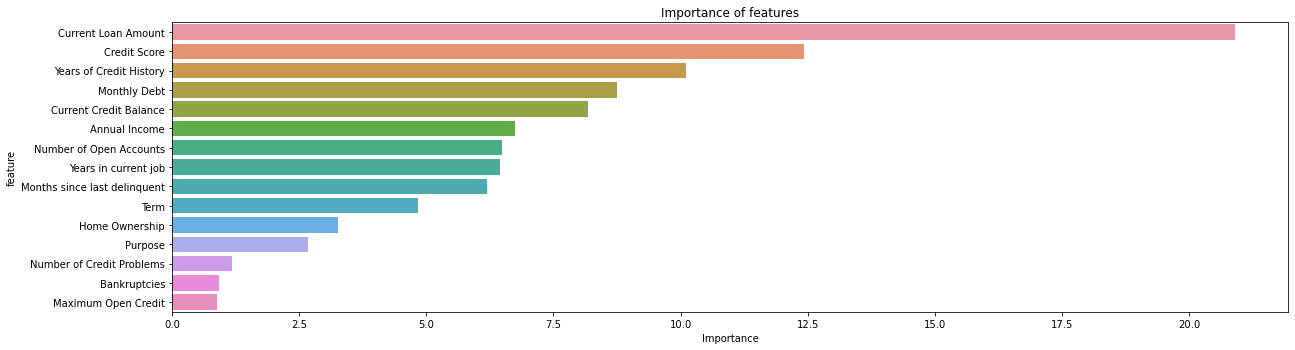

In [70]:
model = models_under['lgbm']
important_features_top = show_feature_importances(SELECTED_FEATURE_NAMES,
                                                  models_under['cat'].feature_importances_, get_top=25)

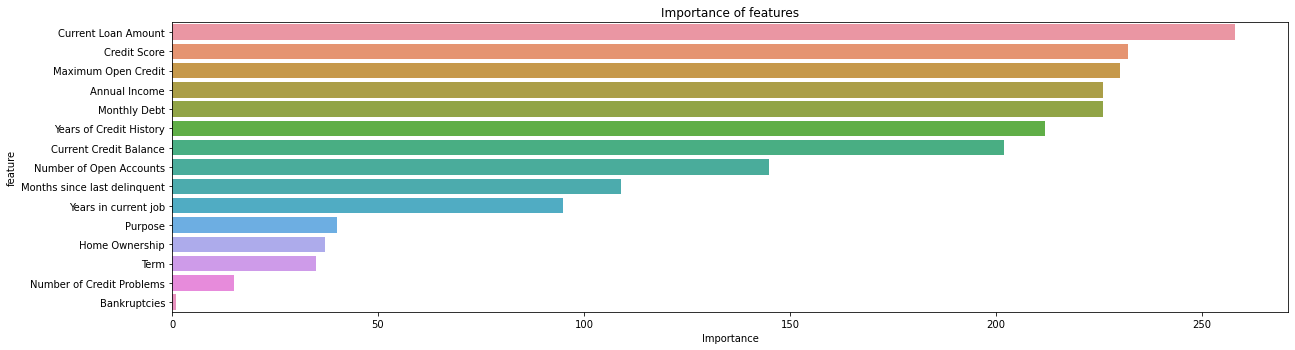

In [71]:
important_features_top = show_feature_importances(SELECTED_FEATURE_NAMES,
                                                  models_under['lgbm'].feature_importances_, get_top=25)

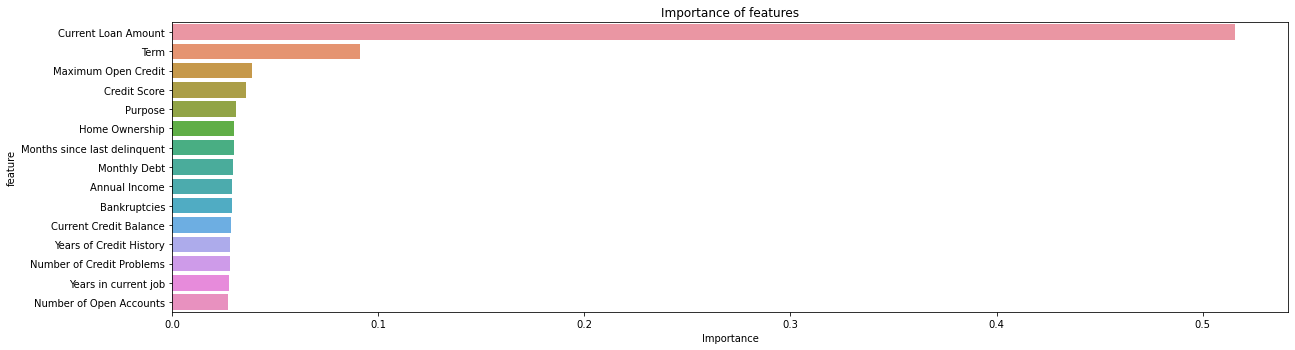

In [72]:
important_features_top = show_feature_importances(SELECTED_FEATURE_NAMES,
                                                  models_under['xgb'].feature_importances_, get_top=25)

In [73]:
df_test = pd.read_csv(TEST_PATH)


In [74]:


df_test.loc[df_test['Years in current job'] == '< 1 year', ['Years in current job']] = 0
df_test.loc[df_test['Years in current job'] == '1 year', ['Years in current job']] = 1
df_test.loc[df_test['Years in current job'] == '2 years', ['Years in current job']] = 2
df_test.loc[df_test['Years in current job'] == '3 years', ['Years in current job']] = 3
df_test.loc[df_test['Years in current job'] == '4 years', ['Years in current job']] = 4
df_test.loc[df_test['Years in current job'] == '5 years', ['Years in current job']] = 5
df_test.loc[df_test['Years in current job'] == '6 years', ['Years in current job']] = 6
df_test.loc[df_test['Years in current job'] == '7 years', ['Years in current job']] = 7
df_test.loc[df_test['Years in current job'] == '8 years', ['Years in current job']] = 8
df_test.loc[df_test['Years in current job'] == '9 years', ['Years in current job']] = 9
df_test.loc[df_test['Years in current job'] == '10+ years', ['Years in current job']] = 10
df_test.loc[df_test['Years in current job'].isna(), ['Years in current job']] = -1


df_test.loc[df_test['Purpose'] == 'debt consolidation', ['Purpose']] = 1
df_test.loc[df_test['Purpose'] == 'other', ['Purpose']] = 2
df_test.loc[df_test['Purpose'] == 'home improvements', ['Purpose']] = 3
df_test.loc[df_test['Purpose'] == 'business loan', ['Purpose']] = 4
df_test.loc[df_test['Purpose'] == 'buy a car', ['Purpose']] = 5
df_test.loc[df_test['Purpose'] == 'medical bills', ['Purpose']] = 6
df_test.loc[df_test['Purpose'] == 'major purchase', ['Purpose']] = 7
df_test.loc[df_test['Purpose'] == 'take a trip', ['Purpose']] = 8
df_test.loc[df_test['Purpose'] == 'buy house', ['Purpose']] = 9
df_test.loc[df_test['Purpose'] == 'small business', ['Purpose']] = 10
df_test.loc[df_test['Purpose'] == 'wedding', ['Purpose']] = 11
df_test.loc[df_test['Purpose'] == 'moving', ['Purpose']] = 12
df_test.loc[df_test['Purpose'] == 'educational expenses', ['Purpose']] = 13
df_test.loc[df_test['Purpose'] == 'vacation', ['Purpose']] = 14
df_test.loc[df_test['Purpose'] == 'renewable energy', ['Purpose']] = 15
df_test.loc[df_test['Purpose'].isna(), ['Purpose']] = -1


df_test.loc[df_test['Term'] == 'Short Term', ['Term']] = 0
df_test.loc[df_test['Term'] == 'Long Term', ['Term']] = 1
df_test.loc[df_test['Term'].isna(), ['Term']] = -1


df_test.loc[df_test['Home Ownership'] == 'Home Mortgage', ['Home Ownership']] = 0
df_test.loc[df_test['Home Ownership'] == 'Rent', ['Home Ownership']] = 1
df_test.loc[df_test['Home Ownership'] == 'Own Home', ['Home Ownership']] = 2
df_test.loc[df_test['Home Ownership'] == 'Have Mortgage', ['Home Ownership']] = 3
df_test.loc[df_test['Home Ownership'].isna(), ['Home Ownership']] = -1

df_test[['Years in current job', 'Purpose', 'Term', 'Home Ownership']] = df_test[['Years in current job', 'Purpose', 'Term', 'Home Ownership']].astype(float)



In [75]:
X__from_test = df_test[SELECTED_FEATURE_NAMES]

In [76]:
pred_train = model.predict(X_train_balanced)
pred_test = model.predict(X__from_test)

evaluate_preds(model, X_train_balanced_under, X_test, y_train_balanced_under,y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.67      0.80      1479
           1       0.75      0.99      0.85      1479

    accuracy                           0.83      2958
   macro avg       0.87      0.83      0.83      2958
weighted avg       0.87      0.83      0.83      2958

TEST

              precision    recall  f1-score   support

           0       0.88      0.39      0.54      1616
           1       0.36      0.86      0.50       634

    accuracy                           0.52      2250
   macro avg       0.62      0.63      0.52      2250
weighted avg       0.73      0.52      0.53      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               633  983
1                88  546


In [77]:
pred_test[10:150]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [78]:
pred_train[10:50]

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0], dtype=int64)

In [79]:
preds_final = pd.DataFrame()
preds_final['Id'] = [i for i in range(len(X__from_test))]
preds_final['Credit Default'] = pred_test
preds_final.to_csv('predictions.csv', index=False)

In [80]:
preds_final = pd.DataFrame()
preds_final['Id'] = [i for i in range(len(X_train_balanced))]
preds_final['Credit Default'] = pred_train
preds_final.to_csv('predictions2.csv', index=False)